In [1]:
# Import packages
import os
import optuna
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_nodes = 7
study_name = f"dcl_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
transforms = "DINO"
projector = "SwAV"
storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_4018511/2985437776.py:6: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-05-08 16:56:07,845] Using an existing study with name 'dcl_7' instead of creating a new one.


In [3]:
study_df = study.trials_dataframe()
complete_df = study_df[study_df.state == "COMPLETE"]
sorted_df = complete_df.sort_values(by="value", ascending=False)

In [1]:
def extract_scalar_arrays(scalar_events):
    wall_times = []
    steps = []
    values = []

    for event in scalar_events:
        wall_times.append(event.wall_time)
        steps.append(event.step)
        values.append(event.value)

    return np.array(wall_times), np.array(steps), np.array(values)


def get_node_name(top_series, model_id, models, ssls, gate_names_list):
    accumulator = EventAccumulator(
        f"runs/{study_name}/{projector}/{transforms}/{top_series.number:04}/{model_id}_{top_series[models[model_id]]}_{top_series[ssls[model_id]]}/"
    )
    accumulator.Reload()
    _, _, values = extract_scalar_arrays(accumulator.Scalars("test_top1"))
    gate_name = top_series[f"params_{model_id}_{model_id}_gate"]
    if gate_name == "CutoffGate" and not all(
        gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]
    ):
        node_name = f"{model_id+1}. {top_series[models[model_id]]}"
    else:
        node_name = f"{model_id+1}. {top_series[models[model_id]]}\n{top_series[ssls[model_id]]}"
    node_name += f"\n{max(values):.2f}%"
    return node_name


def get_edge_color(gate_name):
    return {
        "SSLLoss": "10",
        "MSELoss": "4",
        "KLLoss": "2",
        "PositiveGammaGate": "4",
        "NegativeGammaGate": "2",
    }.get(gate_name, "8")


def create_graph(sorted_df, top):
    top_series = sorted_df.iloc[top]
    models = sorted(list(filter(lambda x: "model" in x, top_series.keys())))
    ssls = sorted(list(filter(lambda x: "ssl" in x, top_series.keys())))

    excluded_nodes = []
    while True:
        gate_names_list = [
            [
                top_series[f"params_{j}_{model_id}_gate"]
                for j, _ in enumerate(models)
                if model_id != j and j not in excluded_nodes
            ]
            for model_id, _ in enumerate(models)
        ]
        new_excluded_nodes = [
            model_id
            for model_id, gate_names in enumerate(gate_names_list)
            if all(gate_name == "CutoffGate" for gate_name in gate_names)
        ]
        if len(excluded_nodes) == len(new_excluded_nodes):
            break
        excluded_nodes = new_excluded_nodes

    gate_names_list = [
        [top_series[f"params_{model_id}_{j}_gate"] for j, _ in enumerate(models)]
        for model_id, _ in enumerate(models)
    ]

    graph = Digraph(format="svg")
    for model_id, _ in enumerate(models):
        if model_id in excluded_nodes:
            continue
        node_color = "pink" if model_id == 0 else "gray90"
        node_name = get_node_name(top_series, model_id, models, ssls, gate_names_list)
        graph.node(node_name, color=node_color, fillcolor=node_color, style="filled")

        for j, _ in enumerate(models):
            gate_name = top_series[f"params_{model_id}_{j}_gate"]
            loss_name = top_series[f"params_{model_id}_{j}_loss"]
            if gate_name == "CutoffGate" or loss_name == "SSLLoss":
                continue
            neighbor_node_name = get_node_name(
                top_series, j, models, ssls, gate_names_list
            )
            edge_color = get_edge_color(gate_name)
            label = (
                gate_name.replace("Gate", "")
                if gate_name in ["PositiveGammaGate", "NegativeGammaGate"]
                else loss_name
            )
            graph.edge(
                neighbor_node_name,
                node_name,
                label=label,
                fontsize="13",
                fontcolor=edge_color,
                color=edge_color,
                colorscheme="paired12",
            )

        if all(gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]):
            graph.node(
                node_name, color="lightblue", fillcolor="lightblue", style="filled"
            )
    return graph

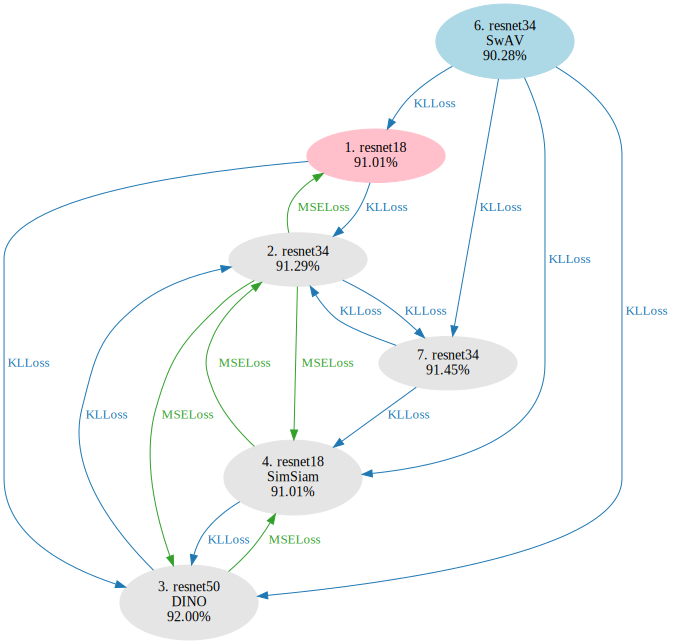

In [5]:
top = 0
G = create_graph(sorted_df, top)
display(G)